Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


NLTK Resources 

In [3]:
# Download NLTK resources for text preprocessing
nltk.download("stopwords")
nltk.download("wordnet")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Qasim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Qasim\AppData\Roaming\nltk_data...


True

Loading dataset

In [16]:
# Load dataset from Kaggle: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

# Assign labels (0 = Fake, 1 = Real)
fake["label"] = 0
true["label"] = 1

# Merge datasets
data = pd.concat([fake, true], axis=0).reset_index(drop=True)

# Shuffle dataset
data = data.sample(frac=1).reset_index(drop=True)

data.head()


,title,text,subject,date,label
0,McConnell calls Army captain Khan 'an American...,WASHINGTON (Reuters) - Senate Majority Leader ...,politicsNews,"July 31, 2016",1
1,RARE INTERVIEW WITH WHITE HOUSE SECRETARY: Bil...,This is a mind-blowing interview that confirms...,Government News,"Jan 17, 2016",0
2,Fewer migrants entitled to join family in Germ...,BERLIN (Reuters) - The number of foreigners wh...,worldnews,"October 19, 2017",1
3,EU lawmakers see little progress in Sri Lanka ...,COLOMBO (Reuters) - European lawmakers said on...,worldnews,"November 2, 2017",1
4,House Speaker Ryan: lawmakers likely to come t...,WASHINGTON (Reuters) - U.S. House Speaker Paul...,politicsNews,"April 14, 2016",1


test preprocessing

In [17]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    tokens = text.split()  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords + Lemmatization
    return " ".join(tokens)

# Apply preprocessing
data["clean_text"] = data["text"].apply(clean_text)

data[["text", "clean_text", "label"]].head()


,text,clean_text,label
0,WASHINGTON (Reuters) - Senate Majority Leader ...,washington reuters senate majority leader mitc...,1
1,This is a mind-blowing interview that confirms...,mindblowing interview confirms much many u sus...,0
2,BERLIN (Reuters) - The number of foreigners wh...,berlin reuters number foreigner qualify join l...,1
3,COLOMBO (Reuters) - European lawmakers said on...,colombo reuters european lawmaker said thursda...,1
4,WASHINGTON (Reuters) - U.S. House Speaker Paul...,washington reuters u house speaker paul ryan t...,1


Train test split

In [18]:
# Features and labels
X = data["clean_text"]
y = data["label"]

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Models training

In [19]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[model_name] = [acc, prec, rec, f1]
    
    print(f"\n===== {model_name} =====")
    print(classification_report(y_test, y_pred))



===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


===== Naive Bayes =====
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4696
           1       0.94      0.95      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980


===== Random Forest =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00

Model performance comparison

Model Performance Comparison:

           Logistic Regression  Naive Bayes  Random Forest
Accuracy              0.986748     0.944321       0.997661
Precision             0.982619     0.935543       0.996275
Recall                0.989729     0.948646       0.998833
F1-score              0.986161     0.942049       0.997552


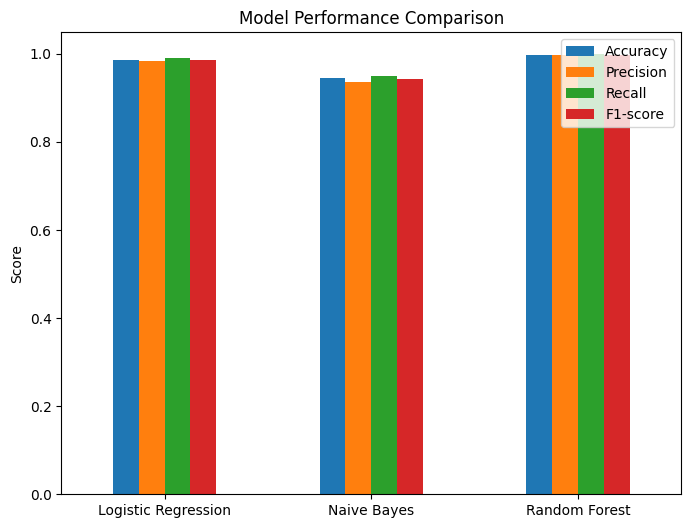

In [20]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score"])
print("Model Performance Comparison:\n")
print(results_df)

# Plot performance
results_df.T.plot(kind="bar", figsize=(8,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


confusion matrix logistic regression

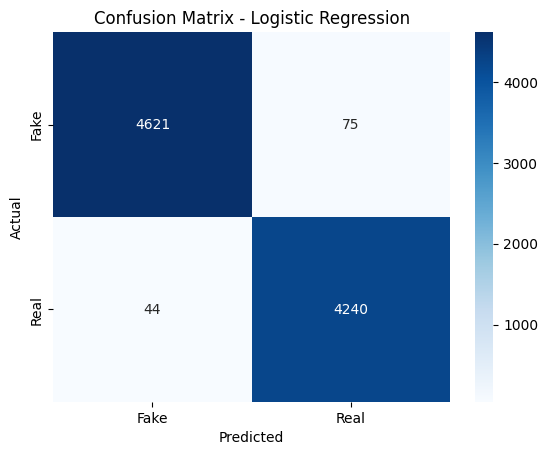

In [22]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


detection of real or fake news

In [25]:
# Function to predict custom news (fixed)
def predict_news(news_text, model=best_model, vectorizer=vectorizer):
    # Apply same preprocessing
    cleaned_text = clean_text(news_text)
    
    if not cleaned_text.strip():  # If empty after cleaning
        print("⚠️ Input too short or contains only stopwords, cannot classify.")
        return
    
    # Transform using SAME vectorizer from training
    vectorized_text = vectorizer.transform([cleaned_text])
    
    # Predict
    prediction = model.predict(vectorized_text)[0]
    prob = model.predict_proba(vectorized_text)[0]  # Confidence score
    
    if prediction == 1:
        print(f"Classified as: REAL  (Confidence: {prob[1]:.2f})")
    else:
        print(f"Classified as: FAKE  (Confidence: {prob[0]:.2f})")

# give input manually
while True:
    user_input = input("\n📰 Enter news text (or type 'exit' to quit): ")
    if user_input.lower() == "exit":
        print("Exiting Terminal.")
        break
    predict_news(user_input)



Classified as: REAL  (Confidence: 0.77)
Classified as: FAKE  (Confidence: 0.92)
Exiting Terminal.
